#Generation of Data sets for Training 

## Generating the Proxy and Full tasks

This notebook serves the purpose of extracting and downsampling patches from the HR versions of the DIV2K image data sets comprising 800 images for training and 100 for validation. Applying data augmentation to this data set, as many patches as possible with 64 x 64 pixels are extracted from the 900 images. 

With these patches we were able to define two tasks with a validation and a training set each. A proxy task that should be significant enough to allow architectural serch for well-performing SRIR models, and a full task to be used for evaluating the final optimal candidate architectures. It is worth noting that the total number of instances for each data task is different.

### Proxy task

The first data set that composes this task considers a total of 522,939 images sampled from the original training data set. The second data set presents 66,650 images extracted from the images included in the validation set. Both sets present a x2 super-resolution task with a set of HR images and lr samples without additional data augmentation. 

These sets are intended to be use complimentarily during the process of architectural search trying to maintain a reduced computational cost.

### Full task

For this task the patches extracted from the original HR images are subjected to data augmentation by flipping horizontally, vertically and rotating 90º. This provides additional patter information to models, such that richer features can be extracted during training.

Disimilar to the proxy task, this one also presents x3 and x4 super resolution data sets such that models can be trained to perform for these problems additionally to x2. This results in 2M images for training and 266,600 images for validation at each resolution.

## Structure of this notebook.

To ease the understanding and application of this notebook, we structured it as follows:

Data normalization. Where the outputs of data will be subjected to min-max normalization, to preserve the relation between results.
Bayesian signed ranked Test. Where the statistical analysis of results will take place.

*   Data Loading and pre-processing. Here image paths are transformed into image arrays and tested for correctness.
*   Creation of directories. Here the structure for image allocation in directories is defined. A compartmentalization of images in subsets is needed as the sheer quantity of files can cause troubles while importing and exporting the patches.
* Extraction of Patches and downsampling. Here each image is subjected to the same operators that sample multiple pieces of each image, apply the data augmentation described in the full task and down sample accordingly to each resolution.
*Data Download. While the datasets will be made public, we include a routine for downloading the data sets generated. 


#Library import and install

## Connection with gdrive to access local DIV2k data sets copies.

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd "../Data_DIV2K/"

Mounted at /gdrive
/gdrive/MyDrive/Doctorate_Thesis_Coding/COMPSR-NET/Data_for_training


##Installing the Patchify and Pillow libraries to handle image processing.

For this we simply install the necessary libraries with !pip install.

In [2]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libraries

We then import the necesary libraries used throughout the notebook.

In [83]:
import os
import glob
import copy

import os.path
from os import path

import time

import numpy as np

from math import floor

from matplotlib import pyplot as plt
from tqdm import tqdm

from IPython.display import display


from patchify import patchify, unpatchify
from PIL import Image

# Transforming images into Arrays

Here we allocate the images from the DIV2K data set. Separate them into training (800) and validation (100) and transform them into arrays.

In [ ]:
train_val_split_perc = 0.888889
val_test_split_perc = 0.5

In [6]:
train_val_split_perc = 0.888889
val_test_split_perc = 0.5
img_paths = []
val_img_paths = []
for dirname, _, filenames in os.walk('../Data_DIV2K/DIV2K_train_HR'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('../Data_DIV2K/DIV2K_valid_HR'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
print('Dataset dimension: ', len(img_paths))

val_img_paths = img_paths[floor(len(img_paths) * train_val_split_perc):]
img_paths = img_paths[:floor(len(img_paths) * train_val_split_perc)]
print('Training: ', len(img_paths))
print('Validation: ', len(val_img_paths))

Dataset dimension:  900
Training:  800
Validation:  100


##Groing from just paths into image arrays

Here we make images more easily accesible by transforming them directly into image arrays.

In [7]:
img_arrays = []
for path in img_paths:
  im = Image.open(path)
  img_arrays.append(np.array(im))

In [8]:
print(len(img_arrays))

800


In [9]:
val_img_arrays = []
for path in val_img_paths:
  im = Image.open(path)
  val_img_arrays.append(np.array(im))

In [10]:
print(len(val_img_arrays))

100


In [11]:
im = Image.open(img_paths[0])

In [12]:
arr = np.array(im)

In [13]:
print(im.format, im.size, im.mode)

PNG (2040, 888) RGB


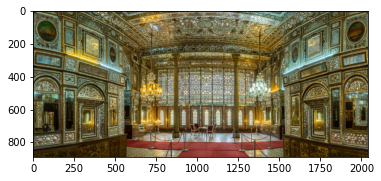

In [14]:
plt.imshow(im)
plt.show()

(888, 2040, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

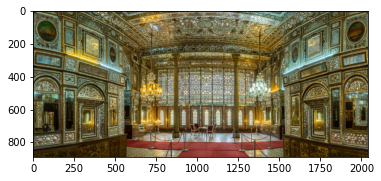

In [15]:
print(img_arrays[0].shape)
arr_ = np.squeeze(img_arrays[0])
plt.imshow(arr_)
plt.show

In [16]:
im = Image.open(val_img_paths[0])
print(im.format, im.size, im.mode)

PNG (1620, 2040) RGB


In [17]:
plt.close()

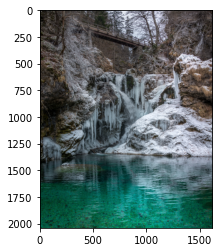

In [18]:
plt.imshow(im)
plt.show()

(2040, 1620, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

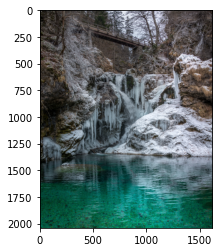

In [19]:
print(val_img_arrays[0].shape)
arr_ = np.squeeze(val_img_arrays[0])
plt.imshow(arr_)
plt.show

In [20]:
plt.close()

# Extracting patches from images.

First we determine the size of the patches, by default our protocol uses 64 by 64 images, but other sizes could be use by a practitioner if needed.

In [53]:
#@title Patch size
size = 64 #@param {type:"number"}

Then we determine the resolution task we wish to generated, this can be x2, x3 or x4 as our protocol suggest. Nonetheless, the structure of this notebook allow further diminishments of resolution on patches. 

In [80]:
#@title Selection of resolution.
Task = 1 #@param {type:"slider", min:1, max:8, step:1}

## Remove processed dataset directories (Only use if needed)

The following instructions allow the quick remotion of direcories in case of encountering an issue that requires them to be generated again. 

In [81]:
!rm -rf /content/Data_set_64/HR

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [ ]:
!rm -rf /content/Data_set_val_64/HR

## Create the required directories

Here we create the directories needed to allocate the data accordingly to resolution and augmentation technique employed.

In [82]:
#Creating the directory for Training set.
import os.path
from os import path

if path.exists(f'/content/Data_set_{size}') == False:

    os.mkdir(f'/content/Data_set_{size}')

    if Task > 1:
      print(Task)
      print(f'/content/Data_set_{size}/x{Task}')
      if path.exists(f'/content/Data_set_{size}/x{Task}') == False:
        os.mkdir(f'/content/Data_set_{size}/x{Task}')
        for i in range(10, 801, 10):
          os.mkdir(f'/content/Data_set_{size}/x{Task}/{i}')
          os.mkdir(f'/content/Data_set_{size}/x{Task}/{i}/Original')
          os.mkdir(f'/content/Data_set_{size}/x{Task}/{i}/Flipped_Horizontally')
          os.mkdir(f'/content/Data_set_{size}/x{Task}/{i}/Flipped_Vertically')
          os.mkdir(f'/content/Data_set_{size}/x{Task}/{i}/Rotated_90')

    else:
      if path.exists(f'/content/Data_set_{size}/HR') == False:
        os.mkdir(f'/content/Data_set_{size}/HR')
        for i in range(10, 801, 10):
          os.mkdir(f'/content/Data_set_{size}/HR/{i}')
          os.mkdir(f'/content/Data_set_{size}/HR/{i}/Original')
          os.mkdir(f'/content/Data_set_{size}/HR/{i}/Flipped_Horizontally')
          os.mkdir(f'/content/Data_set_{size}/HR/{i}/Flipped_Vertically')
          os.mkdir(f'/content/Data_set_{size}/HR/{i}/Rotated_90')

else:

    if Task > 1:
      if path.exists(f'/content/Data_set_{size}/x{Task}') == False:
        os.mkdir(f'/content/Data_set_{size}/x{Task}')
        for i in range(10, 801, 10):
          os.mkdir(f'/content/Data_set_{size}/x{Task}/{i}')
          os.mkdir(f'/content/Data_set_{size}/x{Task}/{i}/Original')
          os.mkdir(f'/content/Data_set_{size}/x{Task}/{i}/Flipped_Horizontally')
          os.mkdir(f'/content/Data_set_{size}/x{Task}/{i}/Flipped_Vertically')
          os.mkdir(f'/content/Data_set_{size}/x{Task}/{i}/Rotated_90')

    else:
      if path.exists(f'/content/Data_set_{size}/HR') == False:
        os.mkdir(f'/content/Data_set_{size}/HR')
        for i in range(10, 801, 10):
          os.mkdir(f'/content/Data_set_{size}/HR/{i}')
          os.mkdir(f'/content/Data_set_{size}/HR/{i}/Original')
          os.mkdir(f'/content/Data_set_{size}/HR/{i}/Flipped_Horizontally')
          os.mkdir(f'/content/Data_set_{size}/HR/{i}/Flipped_Vertically')
          os.mkdir(f'/content/Data_set_{size}/HR/{i}/Rotated_90')

In [84]:
#Creating the directory for Validation set.
import os.path
from os import path

if path.exists(f'/content/Data_set_val_{size}') == False:

    os.mkdir(f'/content/Data_set_val_{size}')

    if Task > 1:
      print(Task)
      print(f'/content/Data_set_val_{size}/x{Task}')
      if path.exists(f'/Data_set_val_/Data_set_{size}/x{Task}') == False:
        os.mkdir(f'/content/Data_set_val_{size}/x{Task}')
        for i in range(10, 101, 10):
          os.mkdir(f'/content/Data_set_val_{size}/x{Task}/{i}')
          os.mkdir(f'/content/Data_set_val_{size}/x{Task}/{i}/Original')
          os.mkdir(f'/content/Data_set_val_{size}/x{Task}/{i}/Flipped_Horizontally')
          os.mkdir(f'/content/Data_set_val_{size}/x{Task}/{i}/Flipped_Vertically')
          os.mkdir(f'/content/Data_set_val_{size}/x{Task}/{i}/Rotated_90')

    else:
      if path.exists(f'/content/Data_set_val_{size}/HR') == False:
        os.mkdir(f'/content/Data_set_val_{size}/HR')
        for i in range(10, 101, 10):
          os.mkdir(f'/content/Data_set_val_{size}/HR/{i}')
          os.mkdir(f'/content/Data_set_val_{size}/HR/{i}/Original')
          os.mkdir(f'/content/Data_set_val_{size}/HR/{i}/Flipped_Horizontally')
          os.mkdir(f'/content/Data_set_val_{size}/HR/{i}/Flipped_Vertically')
          os.mkdir(f'/content/Data_set_val_{size}/HR/{i}/Rotated_90')

else:

    if Task > 1:
      if path.exists(f'/content/Data_set_val_{size}/x{Task}') == False:
        os.mkdir(f'/content/Data_set_val_{size}/x{Task}')
        for i in range(10, 101, 10):
          os.mkdir(f'/content/Data_set_val_{size}/x{Task}/{i}')
          os.mkdir(f'/content/Data_set_val_{size}/x{Task}/{i}/Original')
          os.mkdir(f'/content/Data_set_val_{size}/x{Task}/{i}/Flipped_Horizontally')
          os.mkdir(f'/content/Data_set_val_{size}/x{Task}/{i}/Flipped_Vertically')
          os.mkdir(f'/content/Data_set_val_{size}/x{Task}/{i}/Rotated_90')

    else:
      if path.exists(f'/content/Data_set_val_{size}/HR') == False:
        os.mkdir(f'/content/Data_set_val_{size}/HR')
        for i in range(10, 101, 10):
          os.mkdir(f'/content/Data_set_val_{size}/HR/{i}')
          os.mkdir(f'/content/Data_set_val_{size}/HR/{i}/Original')
          os.mkdir(f'/content/Data_set_val_{size}/HR/{i}/Flipped_Horizontally')
          os.mkdir(f'/content/Data_set_val_{size}/HR/{i}/Flipped_Vertically')
          os.mkdir(f'/content/Data_set_val_{size}/HR/{i}/Rotated_90')

In [85]:
folders = []
for f in range(10, 801, 10):
  folders.append(f)

In [86]:
folders_val = []
for f in range(10,101,10):
  folders_val.append(f)

## Extracting patches and downsampling.

Here are the main blocks of code of this notebook. These focus on the extracting and downsampling of data generating in principle each of the data set tasks.

In [87]:
a = 0
for k in tqdm(range(len(img_arrays))):
  one_image = img_arrays[k]
  #Extracting patches
  patches_img = patchify(one_image, (size,size,3), step = size)   
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i, j, 0, :, :, :]
      
      #From patch array to image
      patch = Image.fromarray(single_patch_img, 'RGB')
      ##From patch array to image flipped horizontally
      patch_FH = patch.transpose(Image.FLIP_LEFT_RIGHT)
      #From patch array to image flipped vertically
      patch_FV = patch.transpose(Image.FLIP_TOP_BOTTOM)
      #From patch array to image rotated 90º
      patch_R = patch.transpose(Image.ROTATE_90)


      #Downsampling original patch by 1/2, 1/3 and 1/4 the size. 
      p_ds = patch.resize((patch.size[0]//Task, patch.size[1]//Task), Image.BICUBIC)
      #Downsampling horizontally flipped patch by 1/2, 1/3 and 1/4 the size.
      p_ds_fh = p_ds.transpose(Image.FLIP_LEFT_RIGHT)
      #Downsampling vertical flipped patch by 1/2, 1/3 and 1/4 the size.
      p_ds_fv = p_ds.transpose(Image.FLIP_TOP_BOTTOM)
      #Downsampling rotated patch by 1/2, 1/3 and 1/4 the size.
      p_ds_r = p_ds.transpose(Image.ROTATE_90)

      # Saving the generated images at different directories for each corresponding image kind.

      if Task == 1:
        if k<folders[a]: 
          patch.save(f"/content/Data_set_{size}/HR/{folders[a]}/Original/patch_{k}_{i}_{j}.jpg")
          patch_FH.save(f"/content/Data_set_{size}/HR/{folders[a]}/Flipped_Horizontally/patch_{k}_{i}_{j}.jpg")
          patch_FV.save(f"/content/Data_set_{size}/HR/{folders[a]}/Flipped_Vertically/patch_{k}_{i}_{j}.jpg")
          patch_R.save(f"/content/Data_set_{size}/HR/{folders[a]}/Rotated_90/patch_{k}_{i}_{j}.jpg")
        
        else:
          #Changing folders.
          a+=1      
          patch.save(f"/content/Data_set_{size}/HR/{folders[a]}/Original/patch_{k}_{i}_{j}.jpg")
          patch_FH.save(f"/content/Data_set_{size}/HR/{folders[a]}/Flipped_Horizontally/patch_{k}_{i}_{j}.jpg")
          patch_FV.save(f"/content/Data_set_{size}/HR/{folders[a]}/Flipped_Vertically/patch_{k}_{i}_{j}.jpg")
          patch_R.save(f"/content/Data_set_{size}/HR/{folders[a]}/Rotated_90/patch_{k}_{i}_{j}.jpg")
      
      else:
        if k<folders[a]: 
          
          p_ds.save(f"/content/Data_set_{size}/x{Task}/{folders[a]}/Original/patch_{k}_{i}_{j}.jpg")
          p_ds_fh.save(f"/content/Data_set_{size}/x{Task}/{folders[a]}/Flipped_Horizontally/patch_{k}_{i}_{j}.jpg")
          p_ds_fv.save(f"/content/Data_set_{size}/x{Task}/{folders[a]}/Flipped_Vertically/patch_{k}_{i}_{j}.jpg")
          p_ds_r.save(f"/content/Data_set_{size}/x{Task}/{folders[a]}/Rotated_90/patch_{k}_{i}_{j}.jpg")

        else:

          #Changing folders.
          a+=1       
          
          p_ds.save(f"/content/Data_set_{size}/x{Task}/{folders[a]}/Original/patch_{k}_{i}_{j}.jpg")
          p_ds_fh.save(f"/content/Data_set_{size}/x{Task}/{folders[a]}/Flipped_Horizontally/patch_{k}_{i}_{j}.jpg")
          p_ds_fv.save(f"/content/Data_set_{size}/x{Task}/{folders[a]}/Flipped_Vertically/patch_{k}_{i}_{j}.jpg")
          p_ds_r.save(f"/content/Data_set_{size}/x{Task}/{folders[a]}/Rotated_90/patch_{k}_{i}_{j}.jpg")

# Uncomment to see some samples of the patches forming the image.
#  rows = patches_img.shape[0]
#  columns =patches_img.shape[1]
#  fig = plt.figure()
#  counter = 1
#
#  if (k+1)%1 == 0:
#    for m in range(patches_img.shape[0]):
#      for n in range(patches_img.shape[1]):
#        fig.add_subplot(rows, columns, counter)
#        counter +=1
#        plt.imshow(patches_img[m, n, 0, :, :, :])
#        plt.axis('off')
#        
#    plt.show()
#    plt.close()

100%|██████████| 800/800 [12:44<00:00,  1.05it/s]


In [91]:
a = 0
for k in tqdm(range(len(val_img_arrays))):
  one_image = val_img_arrays[k]
  patches_img = patchify(one_image, (size,size,3), step = size)
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i, j, 0, :, :, :]

      patch = Image.fromarray(single_patch_img, 'RGB')
      patch_FH = patch.transpose(Image.FLIP_LEFT_RIGHT)
      patch_FV = patch.transpose(Image.FLIP_TOP_BOTTOM)
      patch_R = patch.transpose(Image.ROTATE_90)
      
      p_ds = patch.resize((patch.size[0]//2, patch.size[1]//2), Image.BICUBIC)
      p_ds_fh = p_ds.transpose(Image.FLIP_LEFT_RIGHT)
      p_ds_fv = p_ds.transpose(Image.FLIP_TOP_BOTTOM)
      p_ds_r = p_ds.transpose(Image.ROTATE_90)
      
      if Task == 1:

        if k<folders_val[a]:
          patch.save(f"/content/Data_set_val_{size}/HR/{folders_val[a]}/Original/patch_{k}_{i}_{j}.jpg")
          patch_FH.save(f"/content/Data_set_val_{size}/HR/{folders_val[a]}/Flipped_Horizontally/patch_{k}_{i}_{j}.jpg")
          patch_FV.save(f"/content/Data_set_val_{size}/HR/{folders_val[a]}/Flipped_Vertically/patch_{k}_{i}_{j}.jpg")
          patch_R.save(f"/content/Data_set_val_{size}/HR/{folders_val[a]}/Rotated_90/patch_{k}_{i}_{j}.jpg")

        else:

          a+=1
          
          patch.save(f"/content/Data_set_val_{size}/HR/{folders_val[a]}/Original/patch_{k}_{i}_{j}.jpg")
          patch_FH.save(f"/content/Data_set_val_{size}/HR/{folders_val[a]}/Flipped_Horizontally/patch_{k}_{i}_{j}.jpg")
          patch_FV.save(f"/content/Data_set_val_{size}/HR/{folders_val[a]}/Flipped_Vertically/patch_{k}_{i}_{j}.jpg")
          patch_R.save(f"/content/Data_set_val_{size}/HR/{folders_val[a]}/Rotated_90/patch_{k}_{i}_{j}.jpg")

      else:
        if k<folders_val[a]:
          p_ds.save(f"/content/Data_set_val_{size}/x{Task}/{folders_val[a]}/Original/patch_{k}_{i}_{j}.jpg")
          p_ds_fh.save(f"/content/Data_set_val_{size}/x{Task}/{folders_val[a]}/Flipped_Horizontally/patch_{k}_{i}_{j}.jpg")
          p_ds_fv.save(f"/content/Data_set_val_{size}/x{Task}/{folders_val[a]}/Flipped_Vertically/patch_{k}_{i}_{j}.jpg")
          p_ds_r.save(f"/content/Data_set_val_{size}/x{Task}/{folders_val[a]}/Rotated_90/patch_{k}_{i}_{j}.jpg")

        else:

          a+=1
          
          p_ds.save(f"/content/Data_set_val_{size}/x{Task}/{folders_val[a]}/Original/patch_{k}_{i}_{j}.jpg")
          p_ds_fh.save(f"/content/Data_set_val_{size}/x{Task}/{folders_val[a]}/Flipped_Horizontally/patch_{k}_{i}_{j}.jpg")
          p_ds_fv.save(f"/content/Data_set_val_{size}/x{Task}/{folders_val[a]}/Flipped_Vertically/patch_{k}_{i}_{j}.jpg")
          p_ds_r.save(f"/content/Data_set_val_{size}/x{Task}/{folders_val[a]}/Rotated_90/patch_{k}_{i}_{j}.jpg")

# Uncomment to see some samples of the patches forming the image.
#  rows = patches_img.shape[0]
#  columns =patches_img.shape[1]
#  fig = plt.figure()
#  counter = 1
#
#  if (k+1)%1 == 0:
#    for m in range(patches_img.shape[0]):
#      for n in range(patches_img.shape[1]):
#        fig.add_subplot(rows, columns, counter)
#        counter +=1
#        plt.imshow(patches_img[m, n, 0, :, :, :])
#        plt.axis('off')
#    
#    plt.show()
#    plt.close()

100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


## Testing for the correct number of instances at each dataset.

Here we test that the datasets are complete.

In [103]:
import os
total = 0
for f in range(10, 801, 10):
  FOLDER_PATH1 = f'Data_set_{size}/HR/{f}/Original'
  FOLDER_PATH2 = f'Data_set_{size}/HR/{f}/Flipped_Horizontally'
  FOLDER_PATH3 = f'Data_set_{size}/HR/{f}/Flipped_Vertically'
  FOLDER_PATH4 = f'Data_set_{size}/HR/{f}/Rotated_90'
  ROOT_PATH = '/content'
  total += len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH1)))
  total += len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH2)))
  total += len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH3)))
  total += len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH4)))
print(total)

2091756


In [107]:
import os
total = 0
for f in range(10, 101, 10):
  FOLDER_PATH1 = f'Data_set_val_{size}/HR/{f}/Original'
  FOLDER_PATH2 = f'Data_set_val_{size}/HR/{f}/Flipped_Horizontally'
  FOLDER_PATH3 = f'Data_set_val_{size}/HR/{f}/Flipped_Vertically'
  FOLDER_PATH4 = f'Data_set_val_{size}/HR/{f}/Rotated_90'
  ROOT_PATH = '/content'
  total += len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH1)))
  total += len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH2)))
  total += len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH3)))
  total += len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH4)))
print(total)

266600


In [ ]:
!zip -r /content/Data_set_64/HR /content/Data_set_64/HR

In [ ]:
!zip -r /content/Data_set_val_64/HR /content/Data_set_val_64/HR

In [108]:
from google.colab import files
files.download(f"/content/Data_set_{size}/HR.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>